# Based
- https://www.kaggle.com/code/honganzhu/cmi-piu-competition?scriptVersionId=201912528 Version44 LB0.492

 If you find this notebook useful, please upvote this and the based one.

In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetRegressor
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
SEED = 42
n_splits = 5

# Feature Engineering

- **Feature Selection**: The dataset contains features related to physical characteristics (e.g., BMI, Height, Weight), behavioral aspects (e.g., internet usage), and fitness data (e.g., endurance time). 
- **Categorical Feature Encoding**: Categorical features are mapped to numerical values using custom mappings for each unique category within the dataset. This ensures compatibility with machine learning algorithms that require numerical input.
- **Time Series Aggregation**: Time series statistics (e.g., mean, standard deviation) from the actigraphy data are computed and merged into the main dataset to create additional features for model training.


In [3]:
path = "I:/Kaggle/child-mind-institute-problematic-internet-use/"

In [4]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sample = pd.read_csv(path + 'sample_submission.csv')

In [5]:
print(train.shape)
train.head()

(3960, 82)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(test.shape)
test.head()

(20, 59)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
sample

,id,sii
0,00008ff9,0
1,000fd460,1
2,00105258,2
3,00115b9f,3
4,0016bb22,0
5,001f3379,1
6,0038ba98,2
7,0068a485,3
8,0069fbed,0
9,0083e397,1


In [8]:
data_dict = pd.read_csv(path + 'data_dictionary.csv')
print(data_dict.shape)
data_dict

(81, 6)


,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN
6,Physical Measures,Physical-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical Measures,Physical-BMI,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical Measures,Physical-Height,Height (in),float,NaN,NaN
9,Physical Measures,Physical-Weight,Weight (lbs),float,NaN,NaN


In [9]:
train['id'].nunique()

3960

In [10]:
test['id'].nunique()

20

In [11]:
train_target = train[test.columns]

In [12]:
print(train_target.shape)
train_target.head()

(3960, 59)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
concat_df = pd.concat([train_target, test], ignore_index=True)
print(concat_df.shape)
concat_df.head()

(3980, 59)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
concat_df['total_num_nan'] = concat_df.isna().sum(axis=1)

In [15]:
concat_df['total_num_nan'].describe()

count    3980.000000
mean       26.142462
std        17.257902
min         3.000000
25%         9.000000
50%        24.000000
75%        41.000000
max        55.000000
Name: total_num_nan, dtype: float64

In [16]:
nan_df = concat_df[concat_df['total_num_nan'] == concat_df['total_num_nan'].max()]
print(nan_df.shape)
nan_df.head()

(199, 60)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,total_num_nan
42,023e1b6a,Summer,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55
67,040d103f,Spring,8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55
84,04ccb838,Summer,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55
107,05dc60ef,Spring,12,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55
148,0882b065,Summer,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55


In [17]:
for col in concat_df.columns:
    new_col_name = col + '_isnan'
    concat_df[new_col_name] = concat_df[col].isna().astype(int)

In [18]:
print(concat_df.shape)
concat_df.head()

(3980, 120)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,total_num_nan,id_isnan,Basic_Demos-Enroll_Season_isnan,Basic_Demos-Age_isnan,Basic_Demos-Sex_isnan,CGAS-Season_isnan,CGAS-CGAS_Score_isnan,Physical-Season_isnan,Physical-BMI_isnan,Physical-Height_isnan,Physical-Weight_isnan,Physical-Waist_Circumference_isnan,Physical-Diastolic_BP_isnan,Physical-HeartRate_isnan,Physical-Systolic_BP_isnan,Fitness_Endurance-Season_isnan,Fitness_Endurance-Max_Stage_isnan,Fitness_Endurance-Time_Mins_isnan,Fitness_Endurance-Time_Sec_isnan,FGC-Season_isnan,FGC-FGC_CU_isnan,FGC-FGC_CU_Zone_isnan,FGC-FGC_GSND_isnan,FGC-FGC_GSND_Zone_isnan,FGC-FGC_GSD_isnan,FGC-FGC_GSD_Zone_isnan,FGC-FGC_PU_isnan,FGC-FGC_PU_Zone_isnan,FGC-FGC_SRL_isnan,FGC-FGC_SRL_Zone_isnan,FGC-FGC_SRR_isnan,FGC-FGC_SRR_Zone_isnan,FGC-FGC_TL_isnan,FGC-FGC_TL_Zone_isnan,BIA-Season_isnan,BIA-BIA_Activity_Level_num_isnan,BIA-BIA_BMC_isnan,BIA-BIA_BMI_isnan,BIA-BIA_BMR_isnan,BIA-BIA_DEE_isnan,BIA-BIA_ECW_isnan,BIA-BIA_FFM_isnan,BIA-BIA_FFMI_isnan,BIA-BIA_FMI_isnan,BIA-BIA_Fat_isnan,BIA-BIA_Frame_num_isnan,BIA-BIA_ICW_isnan,BIA-BIA_LDM_isnan,BIA-BIA_LST_isnan,BIA-BIA_SMM_isnan,BIA-BIA_TBW_isnan,PAQ_A-Season_isnan,PAQ_A-PAQ_A_Total_isnan,PAQ_C-Season_isnan,PAQ_C-PAQ_C_Total_isnan,SDS-Season_isnan,SDS-SDS_Total_Raw_isnan,SDS-SDS_Total_T_isnan,PreInt_EduHx-Season_isnan,PreInt_EduHx-computerinternet_hoursday_isnan,total_num_nan_isnan
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,19,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,12,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,20,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [19]:
data_dict

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN
6,Physical Measures,Physical-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical Measures,Physical-BMI,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical Measures,Physical-Height,Height (in),float,NaN,NaN
9,Physical Measures,Physical-Weight,Weight (lbs),float,NaN,NaN


In [20]:
instruments = data_dict['Instrument'].unique().tolist()
instruments.remove('Identifier')
print(len(instruments))
instruments

11


['Demographics',
 "Children's Global Assessment Scale",
 'Physical Measures',
 'FitnessGram Vitals and Treadmill',
 'FitnessGram Child',
 'Bio-electric Impedance Analysis',
 'Physical Activity Questionnaire (Adolescents)',
 'Physical Activity Questionnaire (Children)',
 'Parent-Child Internet Addiction Test',
 'Sleep Disturbance Scale',
 'Internet Use']

In [21]:
for instrument in instruments:
    if 'Parent-Child Internet Addiction Test' == instrument:
        continue
    instrument_df = data_dict[data_dict['Instrument'] == instrument]
    field_list = instrument_df['Field'].unique().tolist()
    concat_df[instrument + '_num_nan'] = concat_df[field_list].isna().sum(axis=1)    

In [22]:
print(concat_df.shape)
concat_df.head()

(3980, 130)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,total_num_nan,id_isnan,Basic_Demos-Enroll_Season_isnan,Basic_Demos-Age_isnan,Basic_Demos-Sex_isnan,CGAS-Season_isnan,CGAS-CGAS_Score_isnan,Physical-Season_isnan,Physical-BMI_isnan,Physical-Height_isnan,Physical-Weight_isnan,Physical-Waist_Circumference_isnan,Physical-Diastolic_BP_isnan,Physical-HeartRate_isnan,Physical-Systolic_BP_isnan,Fitness_Endurance-Season_isnan,Fitness_Endurance-Max_Stage_isnan,Fitness_Endurance-Time_Mins_isnan,Fitness_Endurance-Time_Sec_isnan,FGC-Season_isnan,FGC-FGC_CU_isnan,FGC-FGC_CU_Zone_isnan,FGC-FGC_GSND_isnan,FGC-FGC_GSND_Zone_isnan,FGC-FGC_GSD_isnan,FGC-FGC_GSD_Zone_isnan,FGC-FGC_PU_isnan,FGC-FGC_PU_Zone_isnan,FGC-FGC_SRL_isnan,FGC-FGC_SRL_Zone_isnan,FGC-FGC_SRR_isnan,FGC-FGC_SRR_Zone_isnan,FGC-FGC_TL_isnan,FGC-FGC_TL_Zone_isnan,BIA-Season_isnan,BIA-BIA_Activity_Level_num_isnan,BIA-BIA_BMC_isnan,BIA-BIA_BMI_isnan,BIA-BIA_BMR_isnan,BIA-BIA_DEE_isnan,BIA-BIA_ECW_isnan,BIA-BIA_FFM_isnan,BIA-BIA_FFMI_isnan,BIA-BIA_FMI_isnan,BIA-BIA_Fat_isnan,BIA-BIA_Frame_num_isnan,BIA-BIA_ICW_isnan,BIA-BIA_LDM_isnan,BIA-BIA_LST_isnan,BIA-BIA_SMM_isnan,BIA-BIA_TBW_isnan,PAQ_A-Season_isnan,PAQ_A-PAQ_A_Total_isnan,PAQ_C-Season_isnan,PAQ_C-PAQ_C_Total_isnan,SDS-Season_isnan,SDS-SDS_Total_Raw_isnan,SDS-SDS_Total_T_isnan,PreInt_EduHx-Season_isnan,PreInt_EduHx-computerinternet_hoursday_isnan,total_num_nan_isnan,Demographics_num_nan,Children's Global Assessment Scale_num_nan,Physical Measures_num_nan,FitnessGram Vitals and Treadmill_num_nan,FitnessGram Child_num_nan,Bio-electric Impedance Analysis_num_nan,Physical Activity Questionnaire (Adolescents)_num_nan,Physical Activity Questionnaire (Children)_num_nan,Sleep Disturbance Scale_num_nan,Internet Use_num_nan
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,19,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,4,4,4,0,2,2,3,0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,12,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,0,4,4,0,2,0,0,0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,20,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,17,2,0,0,0
3,00115b9

In [29]:
train_parquet_id_folders_list = os.listdir(path + 'series_train.parquet/')
print(len(train_parquet_id_folders_list))
train_parquet_id_folders_list

996


['id=00115b9f',
 'id=001f3379',
 'id=00f332d1',
 'id=01085eb3',
 'id=012cadd8',
 'id=012e3869',
 'id=029a19c9',
 'id=02cebf33',
 'id=02cf7384',
 'id=035c96dd',
 'id=03a9019b',
 'id=0417c91e',
 'id=045a0a94',
 'id=04afb6f9',
 'id=04bb1a76',
 'id=04cb2c30',
 'id=04d06a9c',
 'id=04f094a8',
 'id=051680a0',
 'id=055156e2',
 'id=059eed01',
 'id=05bbed1b',
 'id=05db1b9b',
 'id=05e94f88',
 'id=063b16fc',
 'id=064e8da5',
 'id=0668373f',
 'id=067b9287',
 'id=06c8b2fb',
 'id=06eb8adb',
 'id=070386b2',
 'id=07048067',
 'id=0720320e',
 'id=0745c390',
 'id=080698b7',
 'id=082df556',
 'id=08577722',
 'id=08660d12',
 'id=089a6b19',
 'id=09331bb8',
 'id=0983654b',
 'id=099e3614',
 'id=09b29113',
 'id=0a418b57',
 'id=0a431608',
 'id=0b4014f0',
 'id=0b50f3fa',
 'id=0b518637',
 'id=0b7d7aec',
 'id=0b7d9da6',
 'id=0bd89878',
 'id=0bfe4fc9',
 'id=0c4e2d68',
 'id=0c4eabac',
 'id=0c98f822',
 'id=0cbe4e54',
 'id=0d01bbf2',
 'id=0d279d77',
 'id=0d4800c8',
 'id=0d4fa8f4',
 'id=0d570d3e',
 'id=0d924604',
 'id=0e3

In [114]:
train_parquet_id_list = [v.replace('id=', '') for v in train_parquet_id_folders_list]
print(len(train_parquet_id_list))
train_parquet_id_list

996


['00115b9f',
 '001f3379',
 '00f332d1',
 '01085eb3',
 '012cadd8',
 '012e3869',
 '029a19c9',
 '02cebf33',
 '02cf7384',
 '035c96dd',
 '03a9019b',
 '0417c91e',
 '045a0a94',
 '04afb6f9',
 '04bb1a76',
 '04cb2c30',
 '04d06a9c',
 '04f094a8',
 '051680a0',
 '055156e2',
 '059eed01',
 '05bbed1b',
 '05db1b9b',
 '05e94f88',
 '063b16fc',
 '064e8da5',
 '0668373f',
 '067b9287',
 '06c8b2fb',
 '06eb8adb',
 '070386b2',
 '07048067',
 '0720320e',
 '0745c390',
 '080698b7',
 '082df556',
 '08577722',
 '08660d12',
 '089a6b19',
 '09331bb8',
 '0983654b',
 '099e3614',
 '09b29113',
 '0a418b57',
 '0a431608',
 '0b4014f0',
 '0b50f3fa',
 '0b518637',
 '0b7d7aec',
 '0b7d9da6',
 '0bd89878',
 '0bfe4fc9',
 '0c4e2d68',
 '0c4eabac',
 '0c98f822',
 '0cbe4e54',
 '0d01bbf2',
 '0d279d77',
 '0d4800c8',
 '0d4fa8f4',
 '0d570d3e',
 '0d924604',
 '0e3b0bd2',
 '0ec403df',
 '0ed2a3c8',
 '0eddd8e5',
 '0f6b71c4',
 '0fbb3ca5',
 '101774f0',
 '101c27f1',
 '108b8659',
 '10ad8c48',
 '10e46254',
 '113f5798',
 '11739de2',
 '119d7562',
 '119e181e',

In [30]:
test_parquet_id_folders_list = os.listdir(path + 'series_test.parquet/')
print(len(test_parquet_id_folders_list))
test_parquet_id_folders_list

2


['id=00115b9f', 'id=001f3379']

In [76]:
i = 0
parquet_list = []
for id_folder in train_parquet_id_folders_list:
    iid = id_folder.replace('id=', '')

    if iid in concat_df['id'].tolist():
        i += 1

    parquet_files_path = path + 'series_train.parquet/' + id_folder + '/'
    parquet_files_list = os.listdir(parquet_files_path)

    dfs_list = []
    for parquet_filename in parquet_files_list:
        parquet_df = pd.read_parquet(parquet_files_path + parquet_filename)
        dfs_list.append(parquet_df)
    parquet_concat_df = pd.concat(dfs_list, ignore_index=True)
    current_cols = parquet_concat_df.columns.tolist()
    parquet_concat_df['id'] = iid
    parquet_concat_df = parquet_concat_df[['id'] + current_cols]
    parquet_concat_df['day_since_wear'] = parquet_concat_df['relative_date_PCIAT'] - parquet_concat_df['relative_date_PCIAT'].min()
    map_dict = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
    parquet_concat_df['weekday_mapped'] = parquet_concat_df['weekday'].map(map_dict)
    parquet_concat_df['time_of_day_sec'] = parquet_concat_df['time_of_day'] / 1e9
    parquet_concat_df['time_of_day_min'] = parquet_concat_df['time_of_day'] / 1e9 / 60
    parquet_concat_df['time_of_day_hour'] = parquet_concat_df['time_of_day'] / 1e9 / 60 / 60
    parquet_concat_df['time_of_day_day'] = parquet_concat_df['time_of_day'] / 1e9 / 60 / 60 / 24
    parquet_concat_df['battery_voltage'] = parquet_concat_df['battery_voltage'] / 1000
    parquet_concat_df['hour'] = parquet_concat_df['time_of_day_hour'].astype(int)
    parquet_concat_df['min'] = parquet_concat_df['time_of_day_min'].astype(int)
    break

In [77]:
print(parquet_concat_df.shape)
parquet_concat_df.head()

(43330, 22)


,id,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,day_since_wear,weekday_mapped,time_of_day_sec,time_of_day_min,time_of_day_hour,time_of_day_day,hour,min
0,00115b9f,0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4.188000,56940000000000,4,3,41.0,0.0,Thursday,56940.0,949.000000,15.816667,0.659028,15,949
1,00115b9f,1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4.188167,56945000000000,4,3,41.0,0.0,Thursday,56945.0,949.083333,15.818056,0.659086,15,949
2,00115b9f,2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4.188334,56950000000000,4,3,41.0,0.0,Thursday,56950.0,949.166667,15.819444,0.659144,15,949
3,00115b9f,3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4.188500,56955000000000,4,3,41.0,0.0,Thursday,56955.0,949.250000,15.820833,0.659201,15,949
4,00115b9f,4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4.181000,57235000000000,4,3,41.0,0.0,Thursday,57235.0,953.916667,15.898611,0.662442,15,953


In [132]:
parquet_concat_df['quarter'].value_counts()

quarter
3    43330
Name: count, dtype: int64

In [55]:
parquet_concat_df['weekday'].value_counts()

weekday
5    10223
7     8566
4     6545
6     5307
1     4780
3     3996
2     3913
Name: count, dtype: int64

In [62]:
parquet_concat_df['time_of_day_sec'].describe()

count    43330.000000
mean     50462.148396
std      19428.423487
min         55.000000
25%      36890.000000
50%      53477.500000
75%      66408.750000
max      86110.000000
Name: time_of_day_sec, dtype: float64

In [65]:
parquet_concat_df['time_of_day_min'].describe()

count    43330.000000
mean       841.035807
std        323.807058
min          0.916667
25%        614.833333
50%        891.291667
75%       1106.812500
max       1435.166667
Name: time_of_day_min, dtype: float64

In [69]:
parquet_concat_df['time_of_day_hour'].describe()

count    43330.000000
mean        14.017263
std          5.396784
min          0.015278
25%         10.247222
50%         14.854861
75%         18.446875
max         23.919444
Name: time_of_day_hour, dtype: float64

In [70]:
parquet_concat_df['time_of_day_day'].describe()

count    43330.000000
mean         0.584053
std          0.224866
min          0.000637
25%          0.426968
50%          0.618953
75%          0.768620
max          0.996644
Name: time_of_day_day, dtype: float64

<Axes: xlabel='light', ylabel='Count'>

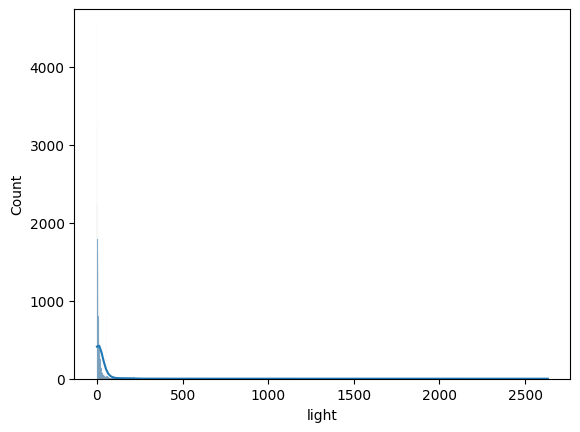

In [78]:
sns.histplot(parquet_concat_df['light'], kde=True)

In [79]:
parquet_concat_df['light'].describe()

count    43330.000000
mean        42.296310
std        208.168976
min          0.000000
25%          2.392969
50%          6.926828
75%         15.000000
max       2633.250000
Name: light, dtype: float64

In [83]:
parquet_concat_df['light'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

count    43330.000000
mean        42.296310
std        208.168976
min          0.000000
1%           0.000752
25%          2.392969
50%          6.926828
75%         15.000000
99%       1102.312003
max       2633.250000
Name: light, dtype: float64

In [81]:
max_df = parquet_concat_df[parquet_concat_df['light'] == parquet_concat_df['light'].max()]
print(max_df.shape)
max_df.head()

(1, 22)


,id,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,day_since_wear,weekday_mapped,time_of_day_sec,time_of_day_min,time_of_day_hour,time_of_day_day,hour,min
34322,00115b9f,34322,-0.717734,-0.237917,-0.541562,0.040889,-34.00227,0.0,2633.25,4.023,38970000000000,2,3,53.0,12.0,Tuesday,38970.0,649.5,10.825,0.451042,10,649


In [84]:
above_95_df = parquet_concat_df[parquet_concat_df['light'] >= parquet_concat_df['light'].quantile(0.95)]
print(above_95_df.shape)
above_95_df.head()

(2167, 22)


,id,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,day_since_wear,weekday_mapped,time_of_day_sec,time_of_day_min,time_of_day_hour,time_of_day_day,hour,min
103,00115b9f,103,-0.558047,-0.573047,0.481562,0.228192,30.076942,0.0,183.000000,4.181,57765000000000,4,3,41.0,0.0,Thursday,57765.0,962.750000,16.045833,0.668576,16,962
106,00115b9f,106,-0.569010,-0.079167,-0.317318,0.246995,-24.308910,0.0,107.199997,4.181,57780000000000,4,3,41.0,0.0,Thursday,57780.0,963.000000,16.050000,0.668750,16,963
107,00115b9f,107,-0.514349,-0.908984,0.264115,1.176841,2.162157,0.0,960.599976,4.181,57785000000000,4,3,41.0,0.0,Thursday,57785.0,963.083333,16.051389,0.668808,16,963
108,00115b9f,108,-0.630208,-0.567448,0.063880,0.146597,2.416042,0.0,797.599976,4.181,57790000000000,4,3,41.0,0.0,Thursday,57790.0,963.166667,16.052778,0.668866,16,963
109,00115b9f,109,-0.629036,-0.657604,0.098724,0.046261,6.339560,0.0,325.600006,4.181,57795000000000,4,3,41.0,0.0,Thursday,57795.0,963.250000,16.054167,0.668924,16,963


<Axes: xlabel='light', ylabel='Count'>

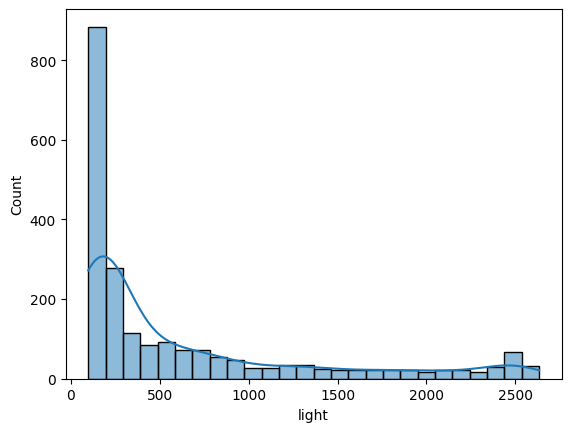

In [85]:
sns.histplot(above_95_df['light'], kde=True)

In [86]:
above_99_df = parquet_concat_df[parquet_concat_df['light'] >= parquet_concat_df['light'].quantile(0.99)]
print(above_99_df.shape)
above_99_df.head()

(434, 22)


,id,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,day_since_wear,weekday_mapped,time_of_day_sec,time_of_day_min,time_of_day_hour,time_of_day_day,hour,min
116,00115b9f,116,-0.292708,-0.897865,-0.279323,0.253807,-15.120733,0.0,2118.199951,4.181,57830000000000,4,3,41.0,0.0,Thursday,57830.0,963.833333,16.063889,0.669329,16,963
117,00115b9f,117,-0.330859,-1.127370,0.046719,0.297017,1.855435,0.0,1921.199951,4.181,57835000000000,4,3,41.0,0.0,Thursday,57835.0,963.916667,16.065278,0.669387,16,963
118,00115b9f,118,-0.179870,-1.077630,0.115781,0.402387,4.683320,0.0,1301.199951,4.181,57840000000000,4,3,41.0,0.0,Thursday,57840.0,964.000000,16.066667,0.669444,16,964
119,00115b9f,119,-0.787943,-0.831536,-0.100313,0.661811,-2.590410,0.0,1367.800049,4.181,57845000000000,4,3,41.0,0.0,Thursday,57845.0,964.083333,16.068056,0.669502,16,964
120,00115b9f,120,-0.280417,-0.987630,-0.134714,0.244897,-8.201444,0.0,1689.800049,4.181,57850000000000,4,3,41.0,0.0,Thursday,57850.0,964.166667,16.069444,0.669560,16,964


<Axes: xlabel='light', ylabel='Count'>

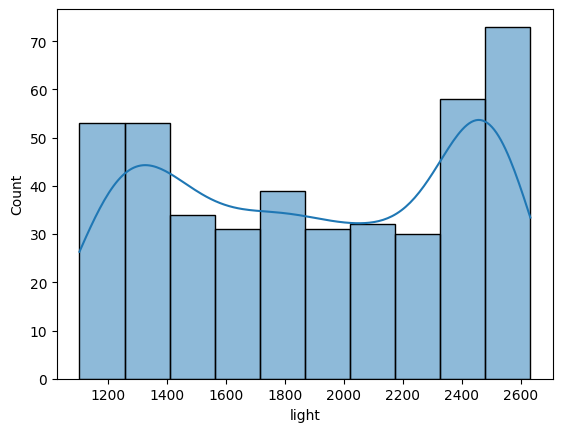

In [87]:
sns.histplot(above_99_df['light'], kde=True)

In [93]:
below_99_df = parquet_concat_df[parquet_concat_df['light'] < parquet_concat_df['light'].quantile(0.99)]
print(below_99_df.shape)
below_99_df.head()

(42896, 22)


,id,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,day_since_wear,weekday_mapped,time_of_day_sec,time_of_day_min,time_of_day_hour,time_of_day_day,hour,min
0,00115b9f,0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4.188000,56940000000000,4,3,41.0,0.0,Thursday,56940.0,949.000000,15.816667,0.659028,15,949
1,00115b9f,1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4.188167,56945000000000,4,3,41.0,0.0,Thursday,56945.0,949.083333,15.818056,0.659086,15,949
2,00115b9f,2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4.188334,56950000000000,4,3,41.0,0.0,Thursday,56950.0,949.166667,15.819444,0.659144,15,949
3,00115b9f,3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4.188500,56955000000000,4,3,41.0,0.0,Thursday,56955.0,949.250000,15.820833,0.659201,15,949
4,00115b9f,4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4.181000,57235000000000,4,3,41.0,0.0,Thursday,57235.0,953.916667,15.898611,0.662442,15,953


<Axes: xlabel='light', ylabel='Count'>

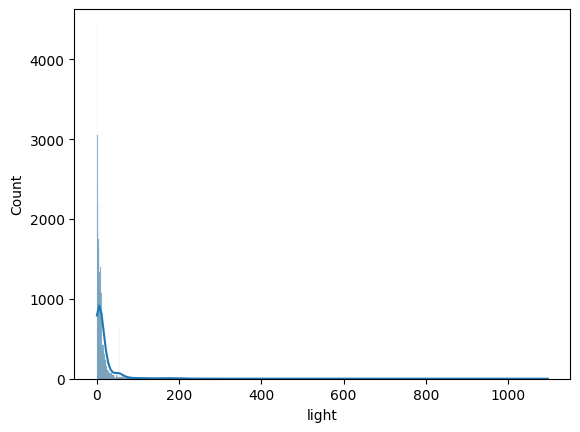

In [94]:
sns.histplot(below_99_df['light'], kde=True)

In [95]:
below_95_df = parquet_concat_df[parquet_concat_df['light'] < parquet_concat_df['light'].quantile(0.95)]
print(below_95_df.shape)
below_95_df.head()

(41163, 22)


,id,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,day_since_wear,weekday_mapped,time_of_day_sec,time_of_day_min,time_of_day_hour,time_of_day_day,hour,min
0,00115b9f,0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4.188000,56940000000000,4,3,41.0,0.0,Thursday,56940.0,949.000000,15.816667,0.659028,15,949
1,00115b9f,1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4.188167,56945000000000,4,3,41.0,0.0,Thursday,56945.0,949.083333,15.818056,0.659086,15,949
2,00115b9f,2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4.188334,56950000000000,4,3,41.0,0.0,Thursday,56950.0,949.166667,15.819444,0.659144,15,949
3,00115b9f,3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4.188500,56955000000000,4,3,41.0,0.0,Thursday,56955.0,949.250000,15.820833,0.659201,15,949
4,00115b9f,4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4.181000,57235000000000,4,3,41.0,0.0,Thursday,57235.0,953.916667,15.898611,0.662442,15,953


<Axes: xlabel='light', ylabel='Count'>

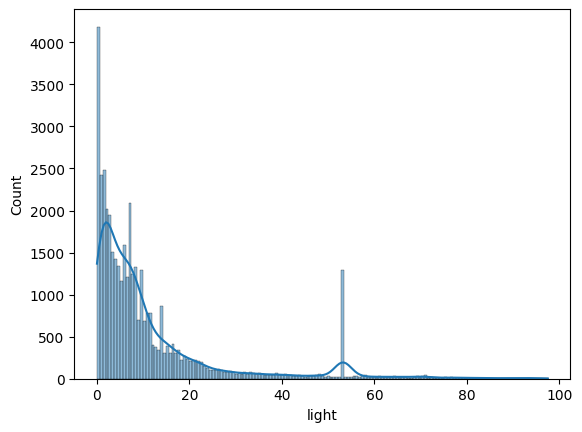

In [96]:
sns.histplot(below_95_df['light'], kde=True)

In [97]:
parquet_concat_df['non-wear_flag'].describe()

count    43330.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: non-wear_flag, dtype: float64

In [ ]:
enmo

<Axes: xlabel='enmo', ylabel='Count'>

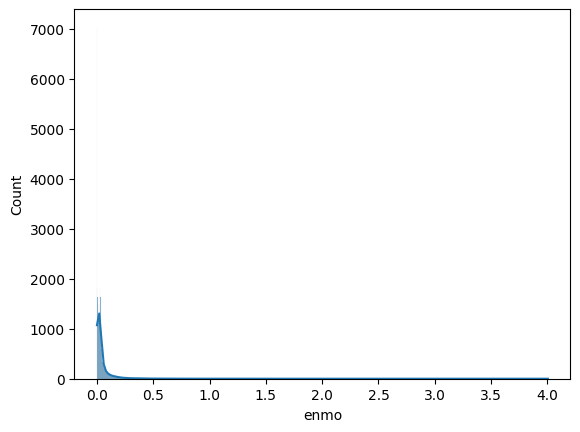

In [98]:
sns.histplot(parquet_concat_df['enmo'], kde=True)

In [101]:
parquet_concat_df['enmo'].describe(percentiles=[0.01] + [0.03] + [i*0.05 + 0.05 for i in range(19)] + [0.97] + [0.99])

count    43330.000000
mean         0.047388
std          0.106351
min          0.000000
1%           0.000000
3%           0.000000
5%           0.000000
10%          0.000332
15%          0.001527
20%          0.003707
25%          0.006432
30%          0.009337
35%          0.012539
40%          0.016204
45%          0.020108
50%          0.023637
55%          0.026687
60%          0.029139
65%          0.031696
70%          0.035379
75%          0.041420
80%          0.051887
85%          0.070719
90%          0.105430
95%          0.180468
97%          0.254348
99%          0.485119
max          4.004276
Name: enmo, dtype: float64

In [102]:
enmo_above_99_df = parquet_concat_df[parquet_concat_df['enmo'] >= parquet_concat_df['enmo'].quantile(0.99)]
print(enmo_above_99_df.shape)
enmo_above_99_df.head()

(434, 22)


,id,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,day_since_wear,weekday_mapped,time_of_day_sec,time_of_day_min,time_of_day_hour,time_of_day_day,hour,min
95,00115b9f,95,-0.353516,0.094792,-0.084922,0.549741,-14.866868,0.0,9.500000,4.181,57725000000000,4,3,41.0,0.0,Thursday,57725.0,962.083333,16.034722,0.668113,16,962
96,00115b9f,96,-0.591771,-0.309922,-0.132083,0.653829,-5.153176,0.0,0.000000,4.181,57730000000000,4,3,41.0,0.0,Thursday,57730.0,962.166667,16.036111,0.668171,16,962
97,00115b9f,97,-0.981172,-1.545990,-0.051823,2.435782,-6.059050,0.0,0.500000,4.181,57735000000000,4,3,41.0,0.0,Thursday,57735.0,962.250000,16.037500,0.668229,16,962
107,00115b9f,107,-0.514349,-0.908984,0.264115,1.176841,2.162157,0.0,960.599976,4.181,57785000000000,4,3,41.0,0.0,Thursday,57785.0,963.083333,16.051389,0.668808,16,963
119,00115b9f,119,-0.787943,-0.831536,-0.100313,0.661811,-2.590410,0.0,1367.800049,4.181,57845000000000,4,3,41.0,0.0,Thursday,57845.0,964.083333,16.068056,0.669502,16,964


<Axes: xlabel='enmo', ylabel='Count'>

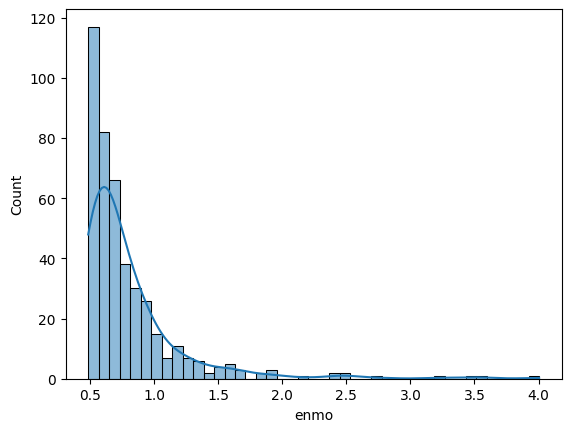

In [105]:
sns.histplot(enmo_above_99_df['enmo'], kde=True)

<Axes: xlabel='X', ylabel='Count'>

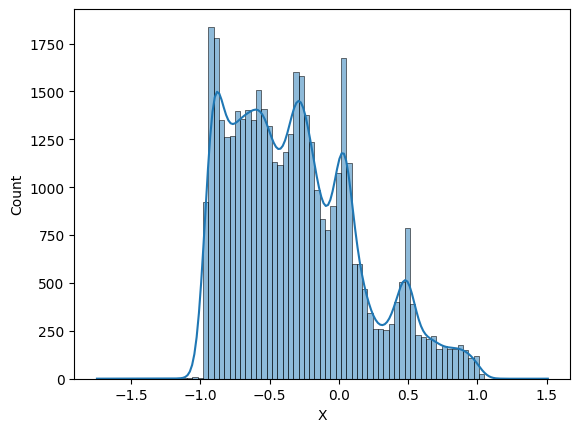

In [106]:
sns.histplot(parquet_concat_df['X'], kde=True)

<Axes: xlabel='Y', ylabel='Count'>

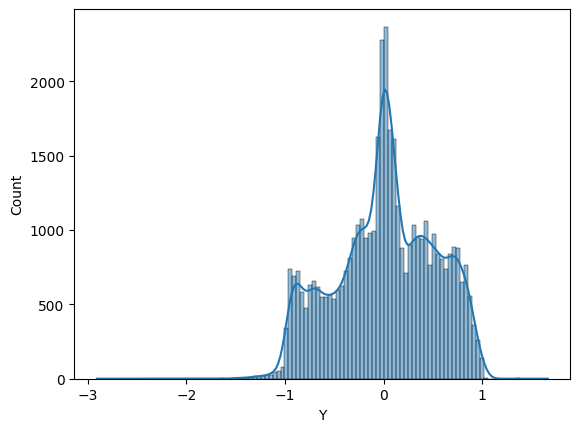

In [110]:
sns.histplot(parquet_concat_df['Y'], kde=True)

<Axes: xlabel='Z', ylabel='Count'>

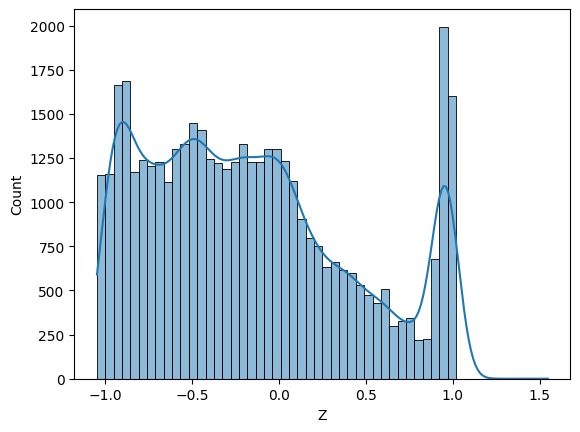

In [111]:
sns.histplot(parquet_concat_df['Z'], kde=True)

In [115]:
has_parquet_df = concat_df[concat_df['id'].isin(train_parquet_id_list)]
print(has_parquet_df.shape)
has_parquet_df.head()

(998, 130)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,total_num_nan,id_isnan,Basic_Demos-Enroll_Season_isnan,Basic_Demos-Age_isnan,Basic_Demos-Sex_isnan,CGAS-Season_isnan,CGAS-CGAS_Score_isnan,Physical-Season_isnan,Physical-BMI_isnan,Physical-Height_isnan,Physical-Weight_isnan,Physical-Waist_Circumference_isnan,Physical-Diastolic_BP_isnan,Physical-HeartRate_isnan,Physical-Systolic_BP_isnan,Fitness_Endurance-Season_isnan,Fitness_Endurance-Max_Stage_isnan,Fitness_Endurance-Time_Mins_isnan,Fitness_Endurance-Time_Sec_isnan,FGC-Season_isnan,FGC-FGC_CU_isnan,FGC-FGC_CU_Zone_isnan,FGC-FGC_GSND_isnan,FGC-FGC_GSND_Zone_isnan,FGC-FGC_GSD_isnan,FGC-FGC_GSD_Zone_isnan,FGC-FGC_PU_isnan,FGC-FGC_PU_Zone_isnan,FGC-FGC_SRL_isnan,FGC-FGC_SRL_Zone_isnan,FGC-FGC_SRR_isnan,FGC-FGC_SRR_Zone_isnan,FGC-FGC_TL_isnan,FGC-FGC_TL_Zone_isnan,BIA-Season_isnan,BIA-BIA_Activity_Level_num_isnan,BIA-BIA_BMC_isnan,BIA-BIA_BMI_isnan,BIA-BIA_BMR_isnan,BIA-BIA_DEE_isnan,BIA-BIA_ECW_isnan,BIA-BIA_FFM_isnan,BIA-BIA_FFMI_isnan,BIA-BIA_FMI_isnan,BIA-BIA_Fat_isnan,BIA-BIA_Frame_num_isnan,BIA-BIA_ICW_isnan,BIA-BIA_LDM_isnan,BIA-BIA_LST_isnan,BIA-BIA_SMM_isnan,BIA-BIA_TBW_isnan,PAQ_A-Season_isnan,PAQ_A-PAQ_A_Total_isnan,PAQ_C-Season_isnan,PAQ_C-PAQ_C_Total_isnan,SDS-Season_isnan,SDS-SDS_Total_Raw_isnan,SDS-SDS_Total_T_isnan,PreInt_EduHx-Season_isnan,PreInt_EduHx-computerinternet_hoursday_isnan,total_num_nan_isnan,Demographics_num_nan,Children's Global Assessment Scale_num_nan,Physical Measures_num_nan,FitnessGram Vitals and Treadmill_num_nan,FitnessGram Child_num_nan,Bio-electric Impedance Analysis_num_nan,Physical Activity Questionnaire (Adolescents)_num_nan,Physical Activity Questionnaire (Children)_num_nan,Sleep Disturbance Scale_num_nan,Internet Use_num_nan
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.0740,4.22033,18.8243,2.0,30.4041,16.7790,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,4,0,2,0,0,0
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.97,1996.45,30.2124,84.0285,16.6877,13.49880,67.9715,2.0,32.9141,20.9020,79.6982,35.3804,63.1265,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring,0.0,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,4,0,0,2,0,0,0
20,00f332d1,Winter,14,0,Spring,68.0,Spring,17.168636,66.5,108.0,NaN,60.0,71.0,129.0,NaN,NaN,NaN,NaN,Spring,16.0,0.0,18.4,1.0,20.9,2.0,22.0,1.0,3.5,0.0,5.5,0.0,13.0,1.0,Spring,4.0,5.93056,17.1705,1414.24,2969.90,27.2818,92.8980,14.7695,2.40101,15.1020,2.0,41.4004,24.2158,86.9674,42.1074,68.6822,NaN,NaN,Winter,2.320,Spring,30.0,43.0,Winter,2.0,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0

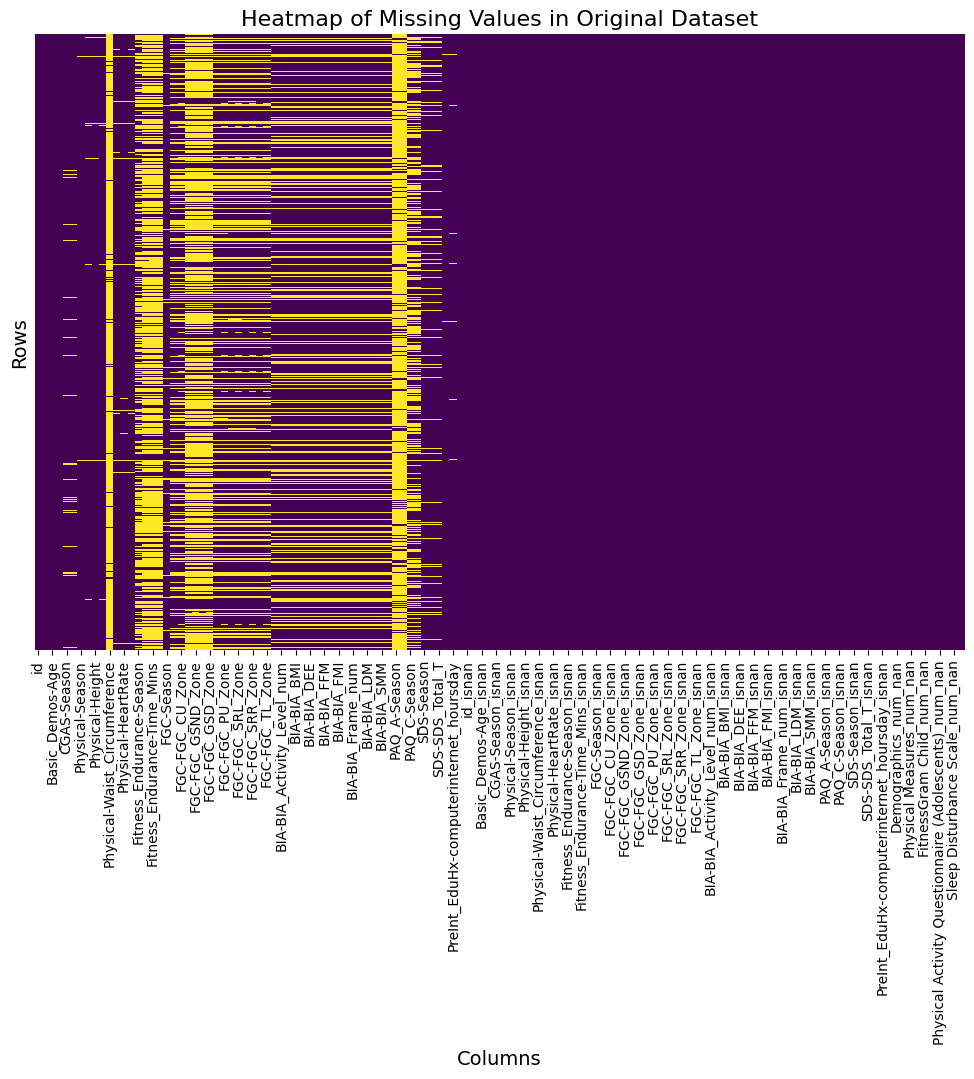

In [117]:
# Visualize missing values in the original dataset using a heatmap
plt.figure(figsize=(12, 8))
plt.title("Heatmap of Missing Values in Original Dataset", fontsize=16)
sns.heatmap(has_parquet_df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.xlabel("Columns", fontsize=14)
plt.ylabel("Rows", fontsize=14)
plt.show()

In [118]:
no_parquet_df = concat_df[~concat_df['id'].isin(train_parquet_id_list)]
print(no_parquet_df.shape)
no_parquet_df.head()

(2982, 130)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,total_num_nan,id_isnan,Basic_Demos-Enroll_Season_isnan,Basic_Demos-Age_isnan,Basic_Demos-Sex_isnan,CGAS-Season_isnan,CGAS-CGAS_Score_isnan,Physical-Season_isnan,Physical-BMI_isnan,Physical-Height_isnan,Physical-Weight_isnan,Physical-Waist_Circumference_isnan,Physical-Diastolic_BP_isnan,Physical-HeartRate_isnan,Physical-Systolic_BP_isnan,Fitness_Endurance-Season_isnan,Fitness_Endurance-Max_Stage_isnan,Fitness_Endurance-Time_Mins_isnan,Fitness_Endurance-Time_Sec_isnan,FGC-Season_isnan,FGC-FGC_CU_isnan,FGC-FGC_CU_Zone_isnan,FGC-FGC_GSND_isnan,FGC-FGC_GSND_Zone_isnan,FGC-FGC_GSD_isnan,FGC-FGC_GSD_Zone_isnan,FGC-FGC_PU_isnan,FGC-FGC_PU_Zone_isnan,FGC-FGC_SRL_isnan,FGC-FGC_SRL_Zone_isnan,FGC-FGC_SRR_isnan,FGC-FGC_SRR_Zone_isnan,FGC-FGC_TL_isnan,FGC-FGC_TL_Zone_isnan,BIA-Season_isnan,BIA-BIA_Activity_Level_num_isnan,BIA-BIA_BMC_isnan,BIA-BIA_BMI_isnan,BIA-BIA_BMR_isnan,BIA-BIA_DEE_isnan,BIA-BIA_ECW_isnan,BIA-BIA_FFM_isnan,BIA-BIA_FFMI_isnan,BIA-BIA_FMI_isnan,BIA-BIA_Fat_isnan,BIA-BIA_Frame_num_isnan,BIA-BIA_ICW_isnan,BIA-BIA_LDM_isnan,BIA-BIA_LST_isnan,BIA-BIA_SMM_isnan,BIA-BIA_TBW_isnan,PAQ_A-Season_isnan,PAQ_A-PAQ_A_Total_isnan,PAQ_C-Season_isnan,PAQ_C-PAQ_C_Total_isnan,SDS-Season_isnan,SDS-SDS_Total_Raw_isnan,SDS-SDS_Total_T_isnan,PreInt_EduHx-Season_isnan,PreInt_EduHx-computerinternet_hoursday_isnan,total_num_nan_isnan,Demographics_num_nan,Children's Global Assessment Scale_num_nan,Physical Measures_num_nan,FitnessGram Vitals and Treadmill_num_nan,FitnessGram Child_num_nan,Bio-electric Impedance Analysis_num_nan,Physical Activity Questionnaire (Adolescents)_num_nan,Physical Activity Questionnaire (Children)_num_nan,Sleep Disturbance Scale_num_nan,Internet Use_num_nan
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,19,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,4,4,4,0,2,2,3,0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.34,Fall,46.0,64.0,Summer,0.0,12,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,0,4,4,0,2,0,0,0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.17,Fall,38.0,54.0,Summer,2.0,20,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,17,2,0,0,0
4,0016bb22,

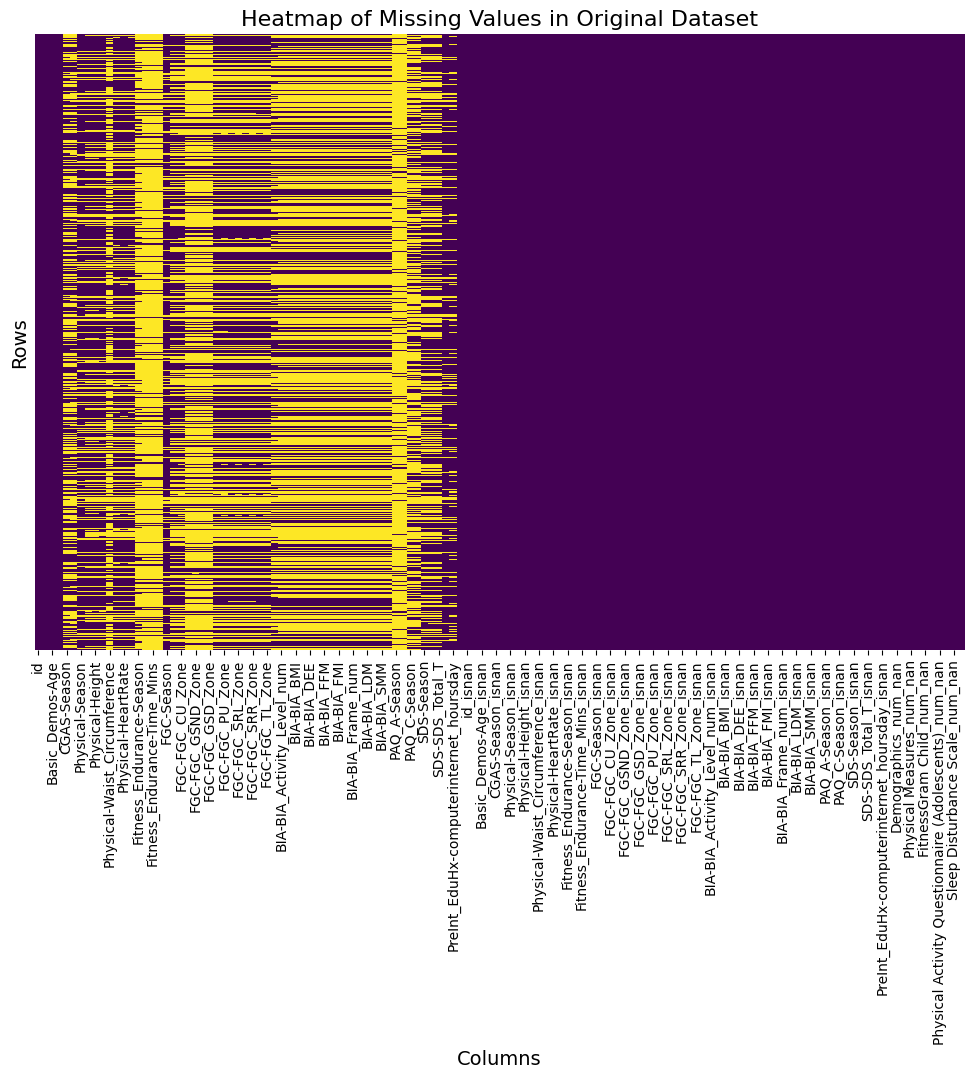

In [119]:
# Visualize missing values in the original dataset using a heatmap
plt.figure(figsize=(12, 8))
plt.title("Heatmap of Missing Values in Original Dataset", fontsize=16)
sns.heatmap(no_parquet_df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.xlabel("Columns", fontsize=14)
plt.ylabel("Rows", fontsize=14)
plt.show()

In [125]:
has_parquet_df.shape

(998, 130)

In [129]:
joined_df = has_parquet_df.join(train['sii'], how='left')
print(joined_df.shape)
joined_df.head()

(998, 131)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,total_num_nan,id_isnan,Basic_Demos-Enroll_Season_isnan,Basic_Demos-Age_isnan,Basic_Demos-Sex_isnan,CGAS-Season_isnan,CGAS-CGAS_Score_isnan,Physical-Season_isnan,Physical-BMI_isnan,Physical-Height_isnan,Physical-Weight_isnan,Physical-Waist_Circumference_isnan,Physical-Diastolic_BP_isnan,Physical-HeartRate_isnan,Physical-Systolic_BP_isnan,Fitness_Endurance-Season_isnan,Fitness_Endurance-Max_Stage_isnan,Fitness_Endurance-Time_Mins_isnan,Fitness_Endurance-Time_Sec_isnan,FGC-Season_isnan,FGC-FGC_CU_isnan,FGC-FGC_CU_Zone_isnan,FGC-FGC_GSND_isnan,FGC-FGC_GSND_Zone_isnan,FGC-FGC_GSD_isnan,FGC-FGC_GSD_Zone_isnan,FGC-FGC_PU_isnan,FGC-FGC_PU_Zone_isnan,FGC-FGC_SRL_isnan,FGC-FGC_SRL_Zone_isnan,FGC-FGC_SRR_isnan,FGC-FGC_SRR_Zone_isnan,FGC-FGC_TL_isnan,FGC-FGC_TL_Zone_isnan,BIA-Season_isnan,BIA-BIA_Activity_Level_num_isnan,BIA-BIA_BMC_isnan,BIA-BIA_BMI_isnan,BIA-BIA_BMR_isnan,BIA-BIA_DEE_isnan,BIA-BIA_ECW_isnan,BIA-BIA_FFM_isnan,BIA-BIA_FFMI_isnan,BIA-BIA_FMI_isnan,BIA-BIA_Fat_isnan,BIA-BIA_Frame_num_isnan,BIA-BIA_ICW_isnan,BIA-BIA_LDM_isnan,BIA-BIA_LST_isnan,BIA-BIA_SMM_isnan,BIA-BIA_TBW_isnan,PAQ_A-Season_isnan,PAQ_A-PAQ_A_Total_isnan,PAQ_C-Season_isnan,PAQ_C-PAQ_C_Total_isnan,SDS-Season_isnan,SDS-SDS_Total_Raw_isnan,SDS-SDS_Total_T_isnan,PreInt_EduHx-Season_isnan,PreInt_EduHx-computerinternet_hoursday_isnan,total_num_nan_isnan,Demographics_num_nan,Children's Global Assessment Scale_num_nan,Physical Measures_num_nan,FitnessGram Vitals and Treadmill_num_nan,FitnessGram Child_num_nan,Bio-electric Impedance Analysis_num_nan,Physical Activity Questionnaire (Adolescents)_num_nan,Physical Activity Questionnaire (Children)_num_nan,Sleep Disturbance Scale_num_nan,Internet Use_num_nan,sii
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.0740,4.22033,18.8243,2.0,30.4041,16.7790,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,4,0,2,0,0,0,1.0
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.97,1996.45,30.2124,84.0285,16.6877,13.49880,67.9715,2.0,32.9141,20.9020,79.6982,35.3804,63.1265,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring,0.0,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,4,0,0,2,0,0,0,1.0
20,00f332d1,Winter,14,0,Spring,68.0,Spring,17.168636,66.5,108.0,NaN,60.0,71.0,129.0,NaN,NaN,NaN,NaN,Spring,16.0,0.0,18.4,1.0,20.9,2.0,22.0,1.0,3.5,0.0,5.5,0.0,13.0,1.0,Spring,4.0,5.93056,17.1705,1414.24,2969.90,27.2818,92.8980,14.7695,2.40101,15.1020,2.0,41.4004,24.2158,86.9674,42.1074,68.6822,NaN,NaN,Winter,2.320,Spring,30.0,43.0,Winter,2.0,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1

In [130]:
joined_df['sii'].info()

<class 'pandas.core.series.Series'>
Index: 998 entries, 3 to 3965
Series name: sii
Non-Null Count  Dtype  
--------------  -----  
996 non-null    float64
dtypes: float64(1)
memory usage: 15.6 KB


In [ ]:
def process_file(id_folder, dirname):
    files = os.listdir(os.path.join(path, dirname, id_folder))
    if len(files) > 1:
        df_list = []
        for file in files:
            df = pd.read_parquet(os.path.join(dirname, id_folder, file))
            df_list.append(df)
        df = pd.concat(df_list, ignore_index=True)
    else:
        df = pd.read_parquet(os.path.join(dirname, id_folder, files[0]))
    
    df.drop('step', axis=1, inplace=True)

    df = df[df['non-wear_flag'] == 0].drop('non-wear_flag', axis=1).reset_index(drop=True)

    describe_df = df.describe(percentiles=[0.01] + [i*0.5/10 + 0.05 for i in range(19)] + [0.99])
    count_mean = describe_df.loc['count', :].mean()
    describe_df.drop('count', axis=0, inplace=True)
    
    return np.append(describe_df.values.reshape(-1), count_mean), id_folder.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*4),
            nn.ReLU(),
            nn.Linear(encoding_dim*4, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim*4),
            nn.ReLU(),
            nn.Linear(encoding_dim*4, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [ ]:
train_ts = load_time_series(path + "series_train.parquet")
test_ts = load_time_series(path + "series_test.parquet")

In [ ]:
concat_ts = pd.concat([train_ts, test_ts], ignore_index=True)
df_concat = concat_ts.drop('id', axis=1)

In [ ]:
for col in df_concat.columns:
    if df_concat[col].std() == 0:
        df_concat.drop(col, axis=1, inplace=True)

In [ ]:
time_series_cols = df_concat.columns.tolist()
df_concat["id"] = concat_ts["id"]
train_ts = df_concat.head(train_ts.shape[0]).reset_index(drop=True)
test_ts = df_concat.tail(test_ts.shape[0]).reset_index(drop=True)
train_merge = pd.merge(train, train_ts, how="left", on='id')
test_merge = pd.merge(test, test_ts, how="left", on='id')

In [ ]:
cat_cols = []
for i in range(data_dict.shape[0]):
    col = data_dict['Field'][i]
    if col == 'id':
        continue
    if (data_dict['Type'][i] == 'str') | ('categori' in data_dict['Type'][i]):
        cat_cols.append(col)

In [ ]:
ordinal_variables = ['FGC-FGC_CU_Zone', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone',
                     'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
                     'PreInt_EduHx-computerinternet_hoursday']

ordinal_variables += [col for col in cat_cols if (('PCIAT' in col)&('Season' not in col))]
print(len(ordinal_variables))
ordinal_variables

In [ ]:
cat_cols = list(set(cat_cols) - set(ordinal_variables))
print(len(cat_cols))
cat_cols

In [ ]:
train_nonan = train_merge.dropna(subset=['sii'], ignore_index=True)
print(train_nonan.shape)
train_nonan.head()

In [ ]:
train_one_hot = train_nonan.copy()
test_one_hot = test_merge.copy()

In [ ]:
for col in cat_cols:
    if 'PCIAT' not in col:
        train_sr = train_one_hot[col].fillna('Missing').apply(str)        
        test_sr = test_one_hot[col].fillna('Missing').apply(str)
        train_one_hot[col] = train_sr
        test_one_hot[col] = test_sr
        concat_sr = pd.concat([train_sr, test_sr])
        unique_list = sorted(concat_sr.unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            train_one_hot[new_col_name] = pd.Series(train_one_hot[col] == v).astype(int)
            test_one_hot[new_col_name] = pd.Series(test_one_hot[col] == v).astype(int)
    else:
        train_sr = train_one_hot[col].fillna('Missing').apply(str)
        train_one_hot[col] = train_sr
        unique_list = sorted(train_sr.unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            train_one_hot[new_col_name] = pd.Series(train_one_hot[col] == v).astype(int)

train_one_hot.drop(cat_cols, axis=1, inplace=True)
test_one_hot.drop([col for col in cat_cols if 'PCIAT' not in col], axis=1, inplace=True)

In [ ]:
print(train_ts.shape)
train_ts.head()

In [ ]:
print(train_one_hot.shape)
train_one_hot.head()

In [ ]:
print(test_one_hot.shape)
test_one_hot.head()

In [ ]:
train_one_hot.drop('id', axis=1, inplace=True)
test_one_hot.drop('id', axis=1, inplace=True)

In [ ]:
train = train_one_hot[test_one_hot.columns.tolist() + ['sii']].copy()
test = test_one_hot.copy()

In [ ]:
print(train.shape)
train.head()

In [ ]:
print(test.shape)
test.head()

In [ ]:
concat_df = pd.concat([train[test.columns], test], ignore_index=True)
print(concat_df.shape)
concat_df.head()

In [ ]:
imputer = KNNImputer(n_neighbors=5)
imputed_data_concat = imputer.fit_transform(concat_df)

In [ ]:
concat_imputed = pd.DataFrame(imputed_data_concat, columns=concat_df.columns)
print(concat_imputed.shape)
concat_imputed.head()

In [ ]:
concat_imputed.isna().sum().sum()

In [ ]:
concat_imputed = feature_engineering(concat_imputed)
print(concat_imputed.shape)
concat_imputed.head()

In [ ]:
if np.any(np.isinf(concat_imputed)):
    print('inf in data')
    concat_imputed = concat_imputed.replace([np.inf, -np.inf], np.nan)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(concat_imputed)

In [ ]:
concat_imputed = pd.DataFrame(imputed_data, columns=concat_imputed.columns)
print(concat_imputed.shape)
concat_imputed.head()

In [ ]:
concat_imputed.isna().sum().sum()

In [ ]:
train_imputed = concat_imputed.head(train.shape[0]).reset_index(drop=True)
test_imputed = concat_imputed.tail(test.shape[0]).reset_index(drop=True)

In [ ]:
train_imputed['sii'] = train['sii']

In [ ]:
train_final = train_imputed.copy()
test_final = test_imputed.copy()

In [ ]:
print(train_final.shape)
print(test_final.shape)

In [ ]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

# Model Training and Evaluation

- **Model Types**: Various models are used, including:
  - **LightGBM**: A gradient-boosting framework known for its speed and efficiency with large datasets.
  - **XGBoost**: Another powerful gradient-boosting model used for structured data.
  - **CatBoost**: Optimized for categorical features without the need for extensive preprocessing.
  - **Voting Regressor**: An ensemble model that combines the predictions of LightGBM, XGBoost, and CatBoost for better accuracy.
- **Cross-Validation**: Stratified K-Folds cross-validation is employed to split the data into training and validation sets, ensuring balanced class distribution in each fold.
- **Quadratic Weighted Kappa (QWK)**: The performance of the models is evaluated using QWK, which measures the agreement between predicted and actual values, taking into account the ordinal nature of the target variable.
- **Threshold Optimization**: The `minimize` function from `scipy.optimize` is used to fine-tune decision thresholds that map continuous predictions to discrete categories (None, Mild, Moderate, Severe).


In [ ]:
def TrainML(model_class, train_data, test_data):
    X = train_data.drop(['sii'], axis=1)
    y = train_data['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission


# Hyperparameter Tuning

- **LightGBM Parameters**: Hyperparameters such as `learning_rate`, `max_depth`, `num_leaves`, and `feature_fraction` are tuned to improve the performance of the LightGBM model. These parameters control the complexity of the model and its ability to generalize to new data.
- **XGBoost and CatBoost Parameters**: Similar tuning is applied for XGBoost and CatBoost, adjusting parameters such as `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and `regularization` terms (`reg_alpha`, `reg_lambda`). These help in controlling overfitting and ensuring the model's robustness.

In [ ]:
Params7 = {
    'learning_rate': 0.03884249148676395,
    'max_depth': 12,
    'num_leaves': 413,
    'min_data_in_leaf': 14,
    'feature_fraction': 0.7987976913702801,
    'bagging_fraction': 0.7602261703576205,
    'bagging_freq': 2,
    'lambda_l1': 4.735462555910575,
    'lambda_l2': 4.735028557007343e-06
} # CV : 0.4094 | LB : 0.471

In [ ]:
Light = LGBMRegressor(**Params7, random_state=SEED, verbose=-1, n_estimators=200)

In [ ]:
Submission1 = TrainML(Light, train_final, test_final)
Submission1.to_csv('submission.csv', index=False)

Submission1